# Question 4

## Rain Removal

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import math
import sortedcontainers
import copy
%matplotlib inline

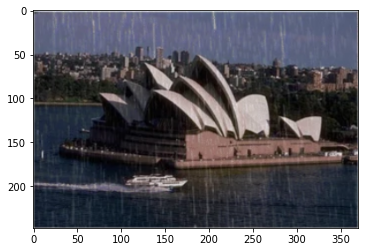

In [2]:
r = cv2.imread("images/rain.png")
r = cv2.cvtColor(r,cv2.COLOR_BGR2RGB)
plt.imshow(r)

In [3]:
def padding(pic,k):
    #Padding
    #Number of row/columns needed for padding is floor(k/2)
    padNum = math.floor(k/2)
#     print(padNum)
    # 2k extra rows and columns are needed to accomodate both sides
    padPic = np.zeros((pic.shape[0]+(2*padNum),pic.shape[1]+(2*padNum),3))
#     print(padPic.shape)
    padPic[padNum:padPic.shape[0]-padNum, padNum:padPic.shape[1]-padNum,:] = pic
    # Image will start from (padNum,padNum)
    xStart = padNum
    xEnd = padPic.shape[0]-padNum
    yStart = padNum
    yEnd = padPic.shape[1]-padNum
#     print(pic.shape)
    padPic[xStart:xEnd, yStart:yEnd] = pic
#     plt.imshow(padPic,cmap='gray')
    return padPic.astype('int')

In [4]:
def paddingC(pic,k):
    #Padding
    #Number of row/columns needed for padding is floor(k/2)
    padNum = math.floor(k/2)
#     print(padNum)
    # 2k extra rows and columns are needed to accomodate both sides
    padPic = np.zeros((pic.shape[0]+(2*padNum),pic.shape[1]+(2*padNum)))
#     print(padPic.shape)
    padPic[padNum:padPic.shape[0]-padNum, padNum:padPic.shape[1]-padNum] = pic
    # Image will start from (padNum,padNum)
    xStart = padNum
    xEnd = padPic.shape[0]-padNum
    yStart = padNum
    yEnd = padPic.shape[1]-padNum
#     print(pic.shape)
    padPic[xStart:xEnd, yStart:yEnd] = pic
#     plt.imshow(padPic,cmap='gray')
    return padPic.astype('int')

In [5]:
def gausFilter(img,s,q):
    k = math.floor(q/2)
    imgP = padding(img,k)
    out = np.zeros_like(imgP)
    sS = 2 * (s ** 2)
    kern = np.zeros([q,q])
    center = int(q/2)
    for i in range(q):
        for j in range(q):
            kern[i][j] = -1*((i-center)**2 + (j-center)**2)/sS
    #For 3D
    kern = np.dstack((kern,kern,kern))
    for i in range(k,imgP.shape[0]-k):
        for j in range(k,imgP.shape[1]-k):
            kernCom = kern
            kernCom = np.exp(kernCom)
            out[i][j] = np.rint(np.sum(imgP[i-center:i+center+1,j-center:j+center+1]*kernCom,axis=(0,1))/np.sum(kernCom,axis=(0,1)))
    out = out[center:out.shape[0]-center,center:out.shape[1]-center,:]
    return out.astype('uint8')

In [6]:
def bilFilter(img,sS,sR,q):
    k = math.floor(q/2)
    imgP = padding(img,k)
    out = np.zeros_like(imgP)
    sS = 2 * (sS ** 2)
    sR = 2 * (sR ** 2)
    kern = np.zeros([q,q])
    center = int(q/2)
    for i in range(q):
        for j in range(q):
            kern[i][j] = -1*((i-center)**2 + (j-center)**2)/sS
    #For 3D
    kern = np.dstack((kern,kern,kern))
    for i in range(k,imgP.shape[0]-k):
        for j in range(k,imgP.shape[1]-k):
            kern1 = -1*(imgP[i-center:i+center+1,j-center:j+center+1]-imgP[i][j])**2/sR
            kernCom = kern + kern1
            kernCom = np.exp(kernCom)
            out[i][j] = np.rint(np.sum(imgP[i-center:i+center+1,j-center:j+center+1]*kernCom,axis=(0,1))/np.sum(kernCom,axis=(0,1)))
                                
    out = out[center:out.shape[0]-center,center:out.shape[1]-center,:]
    return out.astype('uint8')

In [7]:
def fastermedianfilter(img, k):
    imgP = paddingC(img,k)
    preCompRow = sortedcontainers.SortedList()
    preCompCol = sortedcontainers.SortedList()
    padNum = k//2
    r0 = imgP.shape[0]
    c0 = imgP.shape[0]
    xS = padNum
    xE = r0 - padNum
    yS = padNum
    yE = c0 - padNum
    out = np.copy(imgP)
    for i in range(xS,xE):
        # 2 cases: 1) Initial values 2) Precompute for rows
        #Standard
        if i!=xS:
            #Remove upper most rows and iterate through columns
            for l in imgP[i-(padNum+1),0:k]:
                preCompRow.discard(l)
            #Add the next lower row
            for l in imgP[i+padNum,0:k]:
                preCompRow.add(l)
        #Initialisation for the first kernel to be used for next vals
        else:
            for l in range(k):
                for m in range(k):
                    preCompRow.add(imgP[l,m])
        
        for j in range(yS,yE):
            if(j==padNum):
                preCompCol = copy.deepcopy(preCompRow)
            else:
                for l in imgP[i-padNum:i+padNum+1,j-padNum-1]:
                    preCompCol.discard(l)
                for l in imgP[i-padNum:i+padNum+1,j+padNum]:
                    preCompCol.add(l)
            out[i][j] = preCompCol[(int)((k**2)/2)]
    out = out[xS:xE,yS:yE]
    return out.astype('int')

In [12]:
def medianFilter(img,k):
    imgP = paddingC(img,k)
    outP = np.zeros_like(imgP)
    padNum = int(k/2)
    xStart = padNum
    xEnd = imgP.shape[0]-padNum
    yStart = padNum
    yEnd = imgP.shape[1]-padNum
    for i in range(xStart,xEnd):
        for j in range(yStart,yEnd):
            #Surrounding Values
            vals = imgP[i-padNum:i+padNum+1,j-padNum:j+padNum+1]
            vals = np.sort(vals,axis=None)
            index = (len(vals)-1)//2
            outP[i,j] = vals[index]
    outP = outP[xStart:xEnd,yStart:yEnd]
    return outP.astype(int)

## Part 1

In [9]:
k = np.array([3,5,7,9,11,13,15,17])
s = (k-1)/6
#Gaussian Filter
G0 = gausFilter(r,s[0],k[0])
G1 = gausFilter(r,s[1],k[1])
G2 = gausFilter(r,s[2],k[2])
G3 = gausFilter(r,s[3],k[3])
G4 = gausFilter(r,s[4],k[4])
G5 = gausFilter(r,s[5],k[5])
G6 = gausFilter(r,s[6],k[6])
G7 = gausFilter(r,s[7],k[7])

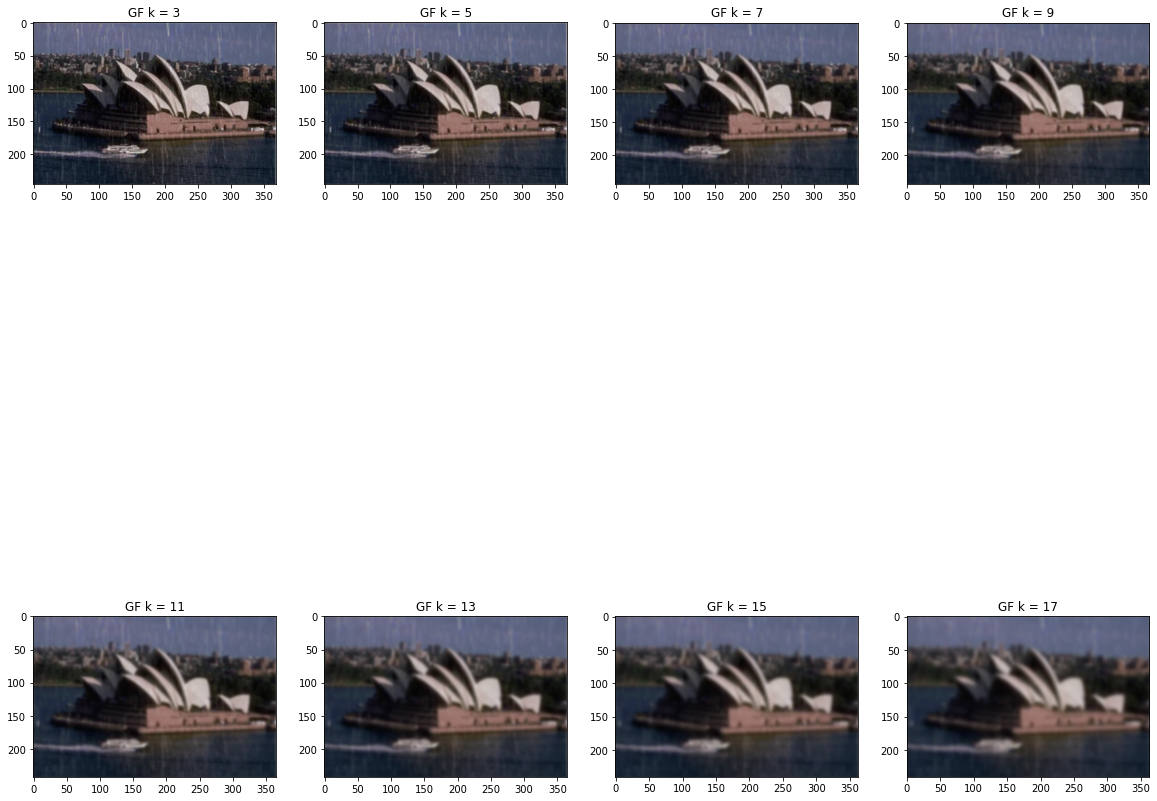

In [10]:
# Plotting Gaussian Filters
f, axarr = plt.subplots(2, 4, figsize=(20,20))
axarr[0][0].imshow(G0)
axarr[0][0].title.set_text('GF k = 3')
axarr[0][1].imshow(G1)
axarr[0][1].title.set_text('GF k = 5')
axarr[0][2].imshow(G2)
axarr[0][2].title.set_text('GF k = 7')
axarr[0][3].imshow(G3)
axarr[0][3].title.set_text('GF k = 9')
axarr[1][0].imshow(G4)
axarr[1][0].title.set_text('GF k = 11')
axarr[1][1].imshow(G5)
axarr[1][1].title.set_text('GF k = 13')
axarr[1][2].imshow(G6)
axarr[1][2].title.set_text('GF k = 15')
axarr[1][3].imshow(G7)
axarr[1][3].title.set_text('GF k = 17')

## Part 2

In [13]:
#Median Filter
M0 = np.dstack((medianFilter(r[:,:,0],k[0]),medianFilter(r[:,:,1],k[0]),medianFilter(r[:,:,2],k[0])))
M1 = np.dstack((medianFilter(r[:,:,0],k[1]),medianFilter(r[:,:,1],k[1]),medianFilter(r[:,:,2],k[1])))
M2 = np.dstack((medianFilter(r[:,:,0],k[2]),medianFilter(r[:,:,1],k[2]),medianFilter(r[:,:,2],k[2])))
M3 = np.dstack((medianFilter(r[:,:,0],k[3]),medianFilter(r[:,:,1],k[3]),medianFilter(r[:,:,2],k[3])))
M4 = np.dstack((medianFilter(r[:,:,0],k[4]),medianFilter(r[:,:,1],k[4]),medianFilter(r[:,:,2],k[4])))
M5 = np.dstack((medianFilter(r[:,:,0],k[5]),medianFilter(r[:,:,1],k[5]),medianFilter(r[:,:,2],k[5])))
M6 = np.dstack((medianFilter(r[:,:,0],k[6]),medianFilter(r[:,:,1],k[6]),medianFilter(r[:,:,2],k[6])))
M7 = np.dstack((medianFilter(r[:,:,0],k[7]),medianFilter(r[:,:,1],k[7]),medianFilter(r[:,:,2],k[7])))

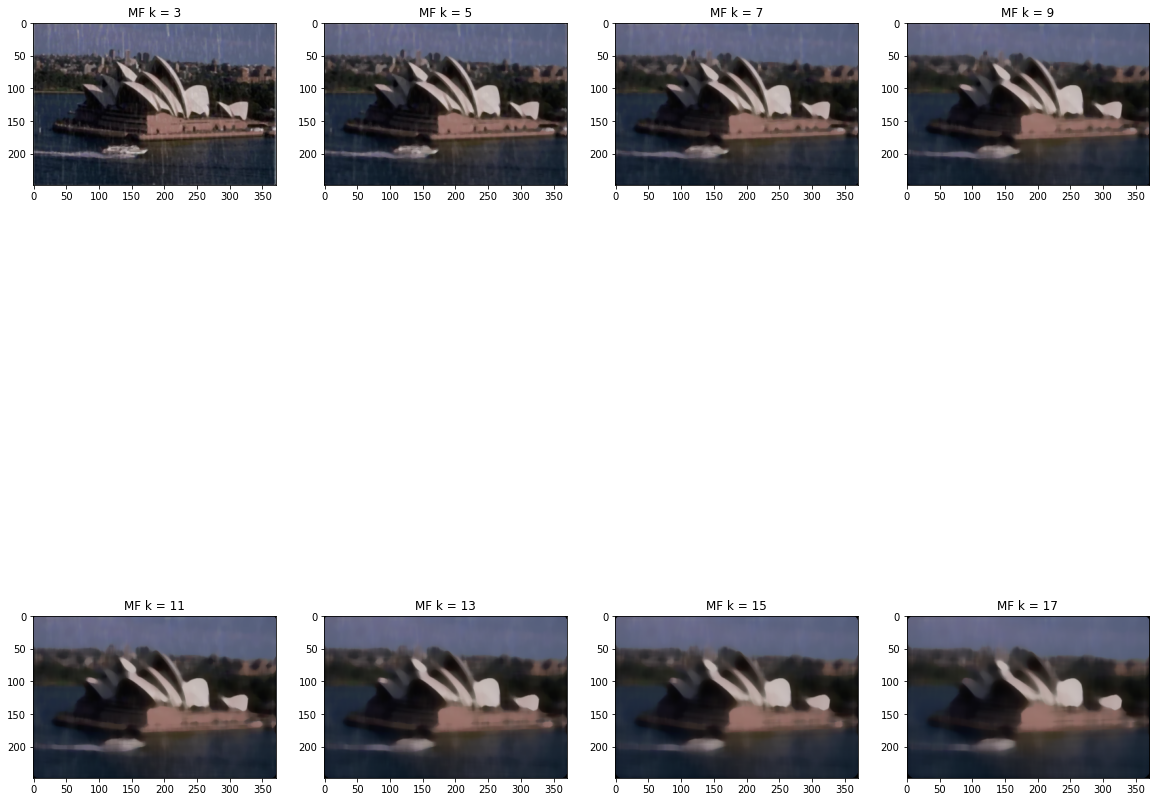

In [14]:
# Plotting Median Filters
f, axarr = plt.subplots(2, 4, figsize=(20,20))
axarr[0][0].imshow(M0)
axarr[0][0].title.set_text('MF k = 3')
axarr[0][1].imshow(M1)
axarr[0][1].title.set_text('MF k = 5')
axarr[0][2].imshow(M2)
axarr[0][2].title.set_text('MF k = 7')
axarr[0][3].imshow(M3)
axarr[0][3].title.set_text('MF k = 9')
axarr[1][0].imshow(M4)
axarr[1][0].title.set_text('MF k = 11')
axarr[1][1].imshow(M5)
axarr[1][1].title.set_text('MF k = 13')
axarr[1][2].imshow(M6)
axarr[1][2].title.set_text('MF k = 15')
axarr[1][3].imshow(M7)
axarr[1][3].title.set_text('MF k = 17')

For k = 11, we get the best output so that the rain is removed but the blurring effect is also not too high

## Part 3

In [15]:
kk = np.array([9,11,13])
sS = np.array([1,40,500])
sR = np.array([1,4,40])
#Bilateral Filter
Bil0 = bilFilter(r,sS[0],sR[0],kk[0])
Bil1 = bilFilter(r,sS[1],sR[1],kk[0])
Bil2 = bilFilter(r,sS[1],sR[2],kk[0])
Bil3 = bilFilter(r,sS[2],sR[2],kk[0])
Bil4 = bilFilter(r,sS[0],sR[0],kk[1])
Bil5 = bilFilter(r,sS[1],sR[1],kk[1])
Bil6 = bilFilter(r,sS[1],sR[2],kk[1])
Bil7 = bilFilter(r,sS[2],sR[2],kk[1])
Bil8 = bilFilter(r,sS[0],sR[0],kk[2])
Bil9 = bilFilter(r,sS[1],sR[1],kk[2])
Bil10= bilFilter(r,sS[1],sR[2],kk[2])
Bil11= bilFilter(r,sS[2],sR[2],kk[2])

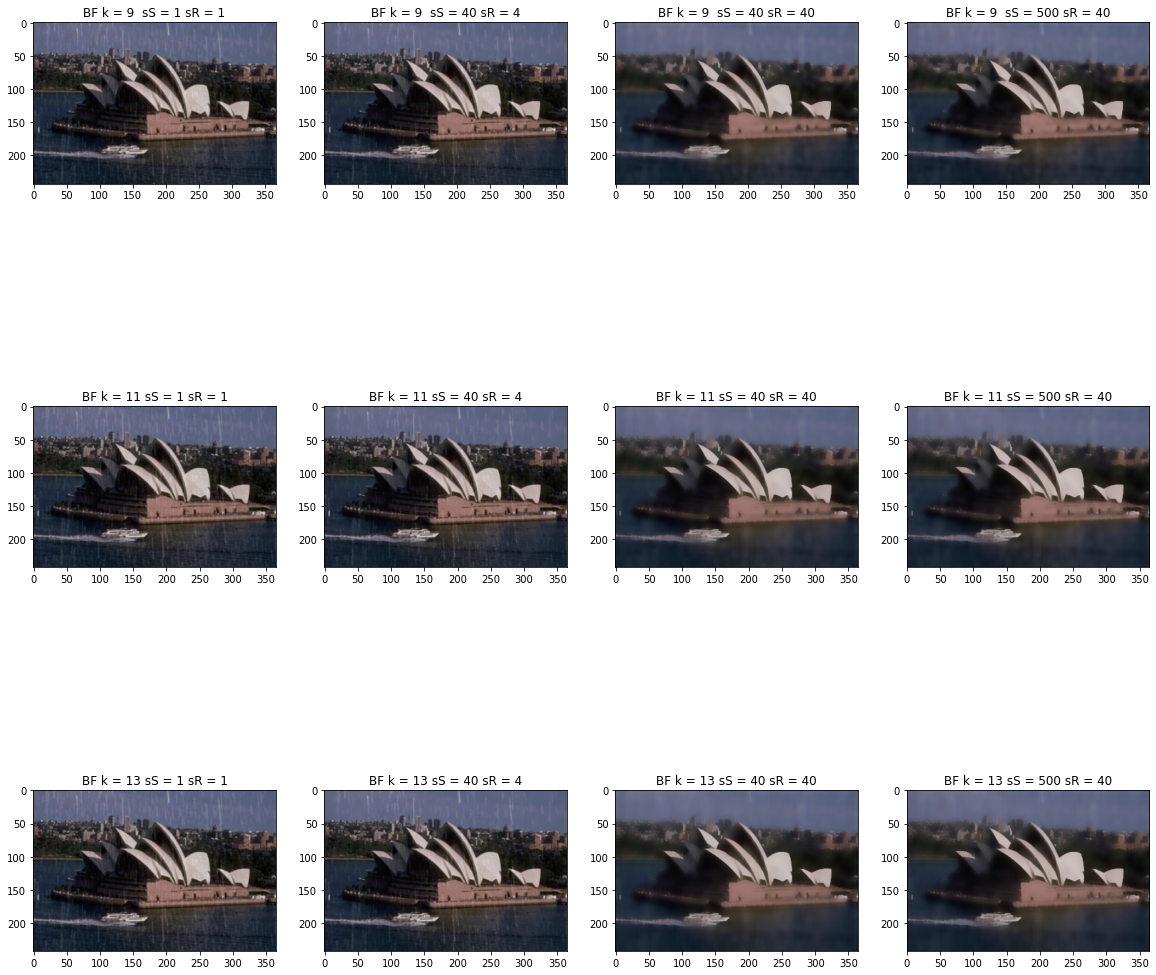

In [16]:
# Plotting Bilateral Filters
f, axarr = plt.subplots(3, 4, figsize=(20,20))
axarr[0][0].imshow(Bil0)
axarr[0][0].title.set_text('BF k = 9  sS = 1 sR = 1')
axarr[0][1].imshow(Bil1)
axarr[0][1].title.set_text('BF k = 9  sS = 40 sR = 4')
axarr[0][2].imshow(Bil2)
axarr[0][2].title.set_text('BF k = 9  sS = 40 sR = 40')
axarr[0][3].imshow(Bil3)
axarr[0][3].title.set_text('BF k = 9  sS = 500 sR = 40')
axarr[1][0].imshow(Bil4)
axarr[1][0].title.set_text('BF k = 11 sS = 1 sR = 1')
axarr[1][1].imshow(Bil5)
axarr[1][1].title.set_text('BF k = 11 sS = 40 sR = 4')
axarr[1][2].imshow(Bil6)
axarr[1][2].title.set_text('BF k = 11 sS = 40 sR = 40')
axarr[1][3].imshow(Bil7)
axarr[1][3].title.set_text('BF k = 11 sS = 500 sR = 40')
axarr[2][0].imshow(Bil8)
axarr[2][0].title.set_text('BF k = 13 sS = 1 sR = 1')
axarr[2][1].imshow(Bil9)
axarr[2][1].title.set_text('BF k = 13 sS = 40 sR = 4')
axarr[2][2].imshow(Bil10)
axarr[2][2].title.set_text('BF k = 13 sS = 40 sR = 40')
axarr[2][3].imshow(Bil11)
axarr[2][3].title.set_text('BF k = 13 sS = 500 sR = 40')

### <b>Part 4</b>

We can observe that for [k = 13,sS = 40,sR = 40] we get the best output for bilateral filter

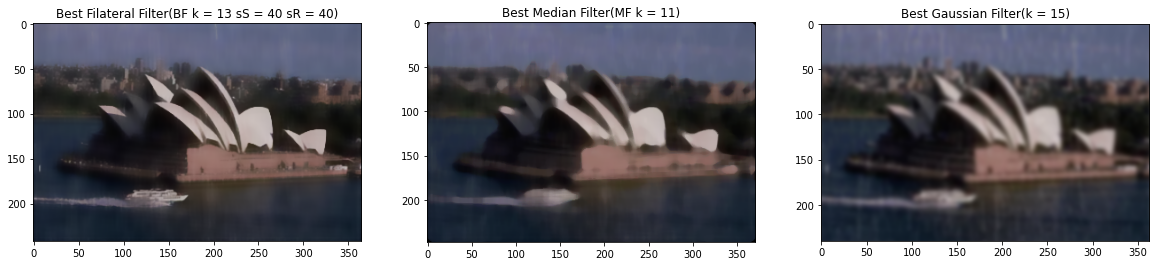

In [21]:
f, axarr = plt.subplots(1, 3, figsize=(20,20))
axarr[0].imshow(Bil10)
axarr[0].title.set_text('Best Filateral Filter(BF k = 13 sS = 40 sR = 40)')
axarr[1].imshow(M4)
axarr[1].title.set_text('Best Median Filter(MF k = 11)')
axarr[2].imshow(G6)
axarr[2].title.set_text('Best Gaussian Filter(k = 15)')

### The best output is obtained in the first figure i.e  Bilateral Filter